# Report

## Gather

- Neste ponto foram feitos esforços para adquirir os dados necessários para o projeto. Primeiramente foi gerado um arquivo no formato `TOML` que contém os tokens usados na API do Twitter, este arquivo é aberto como um dicionário pelo python utilizando a extensão toml. As variáveis constantes (em maiusculo) são criadas com os valores desse token o que facilita a manutenção do código e o objeto da API é criado. São utilizados `wait_on_rate_limit` e `wait_on_rate_limit_notify` para que quando o tempo limite for excedido a api espere para contínuar e avise dessa pausa;
- Utilizando a url fornecida para o projeto 2, o arquivo `image-predictions.tsv` é carregado como um DataFrame diretamente, aproveitando os recursos das ultimas versões do pandas que tem a capacidade de fazer download diretamente ao abrir;
- O arquivo `twitter-archive-enhanced.csv` é carregado como o dataframe `twitter_archive`;
- Utilizando os identificadores do dataframe `image_predicion` e a API do twitter os tweets são baixados no formato json e gravados no arquivo `tweet_json.txt` linha por linha usando a forma de gravação `append` de arquivos do python. Também foi adicionado o comando mágico do ipython `%%time` para calcular o tempo de execução;
- Utilizando o arquivo `tweet_json.txt` acessa cada linha e pega as informações uteis adicionando essas a um dataframe vazio chamado `df_tweets`.

## Assess
- Acessa informações uteis de cada dataframe para entender seus dados, algumas das informações que são acessadas são: `sample(10)` para enchergar 10 amostras aleatorias; `info()` para verificar valores faltantes e tipo de dados de cada coluna; `duplicated()` para verificar se valores estão duplicados. Ainda foram feitas outras visualizações que ajudaram a esclarecer o que poderia ser melhorado, como retweets existentes e replys de tweets originais;
- Cada link de `extended_urls` foi acessado para descobrir tweets inexistentes e assim ficar mais fácil sua remoção;
- Uma lista de tarefas para melhorar a qualidade e arrumação dos dataframes foi criada para servir como guia na limpeza.

## Clean
- Primeiramente, para cada item da lista foi criada uma definição, uma informação do que foi realizado;
- Essa ordem de limpeza foi definida por tabela, onde toda a limpeza de uma tabela era feita antes de prosseguir para a seguinte, a menos que a limpeza não fosse possível;
- A baixo de cada definição, foi realizada a limpeza do código e um ou mais testes para verificar a corretitude da tabela depois da limpeza;
- Ao terminar as limpezas de qualidade se seguiu para as limpezas de arrumação onde foi feita a junção das tabelas com as colunas necessárias e ideais;
- O novo dataframe gerado pela junção ainda teve de receber alguns pontos de limpeza que serviram para melhorar a qualidade antes de salva-lo como `twitter_archive_master.csv`

## Analyze
- Algumas pequenas analises descritivas foram realizadas, com a geração de alguns gráficos e escrito alguns insights.

# Wrangle Act

## Gather

In [1]:
import re
import json
import toml
import time
import tweepy
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load twitter tokens
parse_tokens = toml.load('tokens.toml')

# Set tweepy tokens
CONSUMER_KEY = parse_tokens['tokens']['consumer_key']
CONSUMER_SECRET = parse_tokens['tokens']['consumer_secret']
ACCESS_TOKEN = parse_tokens['tokens']['access_token']
ACCESS_SECRET = parse_tokens['tokens']['access_secret']

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
# Download image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_pretictions = pd.read_table(url)

In [4]:
# Load tweets
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [ ]:
% % time
# Take tweet json by tweet_id:
# *AVISO*: Execução demorada
id_404_erros = []
# tweets = twitter_archive[(twitter_archive.retweeted_status_id.isnull()) & (twitter_archive.in_reply_to_status_id.isnull())]
tweets = image_pretictions
for tweet_id in tweets.tweet_id:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        if tweet.user.id == 4196983835:
            with open('tweet_json.txt', 'a') as outfile:
                json.dump(tweet._json, outfile)
                outfile.write('\n')
    except tweepy.TweepError:
        #         if tweepy.TweepError.message[0]['code'] == 404:
        id_404_erros.append(tweet_id)
        continue

In [7]:
# Gera DataFrame de tweets puxados por id
df_tweets = pd.DataFrame(columns=[
                         'tweet_id', 'text', 'retweet_count', 'favorite_count', 'jpg_url', 'url', 'expanded_urls'])

with open('tweet_json.txt', 'r') as file:
    for line in file:
        try:
            line_json = json.loads(line)
            
            if 'media' not in line_json['entities']:
                continue
            line_dict = {
                'tweet_id': line_json['id_str'],
                'text': line_json['full_text'],
                'retweet_count': line_json['retweet_count'],
                'favorite_count': line_json['favorite_count'],
                'jpg_url': line_json['entities']['media'][0]['media_url_https'],
                'url': line_json['entities']['media'][0]['url'],
                'expanded_urls': line_json['entities']['media'][0]['expanded_url']
            }

            df_tweets = df_tweets.append(
                pd.Series(line_dict).to_frame().transpose(), ignore_index=True) # Transpoem do formato de Serie para DataFrame

        except Exception:
            raise Exception(line)
df_tweets.head()

,tweet_id,text,retweet_count,favorite_count,jpg_url,url,expanded_urls
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,8333,38117,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,This is Tilly. She's just checking pup on you....,6159,32707,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://t.co/0Xxu71qeIV,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,4078,24618,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,8479,41472,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,This is Franklin. He would like you to stop ca...,9170,39643,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,https://t.co/AtUZn91f7f,https://twitter.com/dog_rates/status/891327558...


## Assess

In [64]:
# Show dataframe loaded head.
image_pretictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
925,702539513671897089,https://pbs.twimg.com/media/Cb_r8qTUsAASgdF.jpg,3,Pomeranian,0.714367,True,Shih-Tzu,0.040574,True,silky_terrier,0.032511,True
1323,756651752796094464,https://pbs.twimg.com/media/CoAqwPTW8AAiJlz.jpg,1,Pembroke,0.294808,True,kelpie,0.282301,True,Cardigan,0.112601,True
184,669354382627049472,https://pbs.twimg.com/media/CUoGQjdXAAAkaz2.jpg,1,Chihuahua,0.973990,True,French_bulldog,0.010832,True,Pekinese,0.002099,True
397,673662677122719744,https://pbs.twimg.com/media/CVlUfBbUwAQyfcD.jpg,1,Labrador_retriever,0.957670,True,beagle,0.012413,True,golden_retriever,0.005689,True
554,677644091929329666,https://pbs.twimg.com/ext_tw_video_thumb/67764...,1,Chihuahua,0.626236,True,Italian_greyhound,0.128483,True,swing,0.059840,False
708,685198997565345792,https://pbs.twimg.com/media/CYJQxvJW8AAkkws.jpg,1,dishwasher,0.888829,False,stove,0.013412,False,Old_English_sheepdog,0.009671,True
1465,778624900596654080,https://pbs.twimg.com/media/Cs47N3eWcAEmgiW.jpg,2,Airedale,0.786089,True,Irish_terrier,0.121488,True,Lakeland_terrier,0.014603,True
2017,880095782870896641,https://pbs.twimg.com/media/DDa6ckbXgAAM1vV.jpg,1,miniature_pinscher,0.120298,True,Rhodesian_ridgeback,0.106395,True,beagle,0.106073,True
663,682662431982772225,https://pbs.twimg.com/media/CXlN1-EWMAQdwXK.jpg,1,beagle,0.413824,True,Cardigan,0.263553,True,basset,0.167618,True
1461,778286810187399168,https://pbs.twimg.com/media/Cs0HuUTWcAUpSE8.jpg,1,Boston_bull,0.322070,True,pug,0.229903,True,muzzle,0.101420,False


In [ ]:
image_pretictions.info()

In [ ]:
image_pretictions.loc[image_pretictions.jpg_url.isnull(), :]

In [122]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2283,667200525029539841,NaN,NaN,2015-11-19 04:39:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Joshwa. He is a fuckboy supreme. He cl...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667200525...,11,10,Joshwa,None,None,None,None
797,773191612633579521,NaN,NaN,2016-09-06 16:10:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Grey. He's the dogtor in charge of you...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/773191612...,12,10,Grey,None,None,None,None
905,758099635764359168,NaN,NaN,2016-07-27 00:40:12 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",In case you haven't seen the most dramatic sne...,NaN,NaN,NaN,https://vine.co/v/hQJbaj1VpIz,13,10,None,None,None,None,None
835,768193404517830656,NaN,NaN,2016-08-23 21:09:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Gerald. He's a fairly exotic doggo. Floof...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768193404...,8,10,Gerald,doggo,None,None,None
1774,678023323247357953,6.780211e+17,4.196984e+09,2015-12-19 01:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After getting lost in Reese's eyes for several...,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
1264,709918798883774466,NaN,NaN,2016-03-16 01:46:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Watson. He's a Suzuki Tickleboop. Leader ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709918798...,12,10,Watson,None,None,None,None
2239,667937095915278337,NaN,NaN,2015-11-21 05:26:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog resembles a baked potato. Bed looks u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667937095...,3,10,None,None,None,None,None
275,840696689258311684,NaN,NaN,2017-03-11 22:51:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I didn't even have to intervene. Took him 4 mi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/840696689...,10,10,None,None,None,None,None
361,829501995190984704,NaN,NaN,2017-02-09 01:27:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He was a skater pup. She said see...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/829501995...,12,10,Leo,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [ ]:
# Retweets e replys
twitter_archive.info()

In [ ]:
# Formato do texto
twitter_archive.loc[0, 'text']

In [ ]:
# Retweet externo existente
twitter_archive.loc[546, :]

In [ ]:
# Reply
twitter_archive.loc[twitter_archive.in_reply_to_status_id.notnull(), :]
twitter_archive.loc[149, :]

In [ ]:
# Lista de replys
twitter_archive[twitter_archive.in_reply_to_status_id.notnull()]

In [ ]:
# Lista de retweets
twitter_archive[twitter_archive.retweeted_status_id.notnull()]

In [ ]:
# Valores que não foram verificados com machine learning
temp = pd.merge(twitter_archive, image_pretictions,
                on=['tweet_id'], how='outer')
temp[temp.p1.isnull()]

In [ ]:
# Verificando existencia de duplicados
twitter_archive.tweet_id.duplicated().sum()

In [ ]:
image_pretictions.tweet_id.duplicated().sum()

In [125]:
twitter_archive[twitter_archive.rating_numerator == 1776].text.values

array(["This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"],
      dtype=object)

In [6]:
# Mostra linhas que url retorna erro 404
twitter_archive[twitter_archive.tweet_id.isin(id_404)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657...,14,10,None,None,None,None,None
190,855857698524602368,NaN,NaN,2017-04-22 18:55:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...","HE'S LIKE ""WAIT A MINUTE I'M AN ANIMAL THIS IS...",NaN,NaN,NaN,https://twitter.com/perfy/status/8558573181681...,13,10,None,None,None,None,None
237,847157206088847362,NaN,NaN,2017-03-29 18:43:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Daisy. She's been pup for adoption for mo...,NaN,NaN,NaN,"https://www.petfinder.com/petdetail/37334596,h...",11,10,Daisy,None,None,None,None
256,843981021012017153,NaN,NaN,2017-03-21 00:22:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",HE WAS DOING A SNOOZE NO SHAME IN A SNOOZE 13/...,NaN,NaN,NaN,https://twitter.com/brianstack153/status/79679...,13,10,None,None,None,None,None
298,837012587749474308,NaN,NaN,2017-03-01 18:52:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KennyFromDaBlok: 14/10 h*ckin good hats. w...,8.370113e+17,7.266347e+08,2017-03-01 18:47:10 +0000,https://twitter.com/KennyFromDaBlok/status/837...,14,10,None,None,None,None,None
323,834089966724603904,NaN,NaN,2017-02-21 17:18:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE...,NaN,NaN,NaN,https://twitter.com/stevekopack/status/8340866...,10,10,None,doggo,None,None,None
344,832032802820481025,NaN,NaN,2017-02-16 01:04:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Miguel. He was the only remaining dogg...,NaN,NaN,NaN,"https://www.petfinder.com/petdetail/34918210,h...",12,10,Miguel,doggo,None,None,None
577,800855607700029440,NaN,NaN,2016-11-22 00:17:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Lin_Manuel: 11/10 would recommend. https:/...,8.008540e+17,7.992370e+07,2016-11-22 00:10:52 +0000,https://twitter.com/littlewiewel/status/800852...,11,10,None,None,None,None,None
742,780476555013349377,NaN,NaN,2016-09-26 18:38:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Patreon: Well. @dog_rates is on Patreon. \...,7.804657e+17,1.228326e+09,2016-09-26 17:55:00 +0000,"https://www.patreon.com/WeRateDogs,https://twi...",12,10,None,None,None,None,None


In [5]:
%% time
# Verificando links de tweets inexistentes
# AVISO: Execução demorada.
count = 0
id_404 = []
for index, row in twitter_archive[twitter_archive.expanded_urls.notna()].iterrows():
    if requests.get(row.expanded_urls.split(',')[0]).status_code == 404:
        print(row.expanded_urls.split(',')[0])
        count += 1
        id_404.append(row.tweet_id)
count

https://twitter.com/4bonds2carbon/status/885517367337512960
https://twitter.com/loganamnosis/status/872657584259551233/photo/1
https://twitter.com/perfy/status/855857318168150016
https://www.petfinder.com/petdetail/37334596
https://twitter.com/brianstack153/status/796796054100471809
https://twitter.com/KennyFromDaBlok/status/837011344666812416/photo/1
https://twitter.com/stevekopack/status/834086676934836224
https://www.petfinder.com/petdetail/34918210
https://twitter.com/littlewiewel/status/800852955880628224
https://www.patreon.com/WeRateDogs
https://weratedogs.com/pages/about-us
https://twitter.com/dog_rates/status/754011816964026368/photo/1


12

In [ ]:
df_tweets.sample(10)

In [ ]:
# valores duplicados
df_tweets.tweet_id.value_counts().head(10)

### Quality

#### `image_pretictions` table
- <del>Tipo de dados errado em `tweet_id`;</de>
- <del>Textos com diferentes formas minusculos e maiusculos nas colunas `p1`, `p2` e `p3`;</del>
- <del>Separação dos textos das colunas `p1`, `p2` e `p3` usando `_` ao invés de espaço.</del>

#### `twitter_archive` table
- <del>`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` com valores incorres no formato `6.67152e+17`;</del>
- <del>Tipo de dados errado em `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `timestamp`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`;</del>
- <del>Valores nulos sendo representados como `nan` ao invés de `NaN` nas `colunas in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_id` e `retweeted_status_user_id`;</del>
- <del>Valores nulos sendo representados como `None` em `doggo`, `floofer`, `pupper` e `puppo`;</del>
- <del>Url repetidas na coluna `expanded_urls`;</del>
- <del>Alguns links em expanded_urls levam a páginas com error 404;</de>
- <del>Nem todos os ids tem predições.</del>
- <del>Urls vazias;</del>
- <del>Nomes de pets como `None` e `a`.</del>

#### `df_tweets` table
-

#### `twitter_archive_master` table
- <del>Limpar urls que não levam a dog_rates</del>

### Tidiness
- <del>Colunas `source` desnecessária em `twitter_archive`;</del>
- <del>Retweets existentes, colunas `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`.</del>
- <del>Replys existentes, colunas `in_reply_to_status_id`, `in_reply_to_user_id`;</del>
- <del>`text` contém (texto, nota, url) em `twitter_archive` e `df_tweets`;</del>
- <del>Quatro colunas em `twitter_archive` (`doggo`, `floofer`, `pupper` e `puppo`) ao invés de uma;</del>
- <del>Denominador se mostra desnecessário sendo sempre 10 em `twitter_archive` na coluna `rating_denominator`;</del>
- <del>Colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`;</del>
- <del>Numero de imagens na coluna `img_num` se mostra desnecessário em `image_predictions`.</del>
- <del>Junção de `df_tweets`, `image_predicitions` e `twitter_archive`;</del>

## Clean

In [8]:
image_pretictions_clean = image_pretictions.copy()
twitter_archive_clean = twitter_archive.copy()
df_tweets_clean = df_tweets.copy()

### Clean - `image_pretictions` table
#### Define - Tipo de dados errado em `tweet_id`
- Modifica o tipos dos valores da coluna `tweet_id` de inteiro para string usando `astype`

#### Code

In [9]:
image_pretictions_clean.tweet_id = image_pretictions_clean.tweet_id.astype(
    'str')

#### Test

In [ ]:
image_pretictions_clean.info()

#### Define
- Textos com diferentes formas minusculos e maiusculos nas colunas p1, p2 e p3

#### Code

In [10]:
image_pretictions_clean.p1 = image_pretictions_clean.p1.apply(
    lambda x: x.lower().replace('_', ' '))
image_pretictions_clean.p2 = image_pretictions_clean.p2.apply(
    lambda x: x.lower().replace('_', ' '))
image_pretictions_clean.p3 = image_pretictions_clean.p3.apply(
    lambda x: x.lower().replace('_', ' '))

#### Test

In [ ]:
image_pretictions_clean.p1.sample(10)

In [ ]:
image_pretictions_clean.p2.sample(10)

In [ ]:
image_pretictions_clean.p3.sample(10)

### Clean - `twitter_archive` table

#### Define - Valores nulos sendo representados como `None` em `doggo`, `floofer`, `pupper` e `puppo`
- Modifica valores `None` para `np.nan` nas colunas `doggo`, `floofer`, `pupper` e `puppo`

#### Code

In [11]:
twitter_archive_clean.doggo = twitter_archive_clean.doggo.apply(
    lambda x: np.nan if x == 'None' else x)
twitter_archive_clean.floofer = twitter_archive_clean.floofer.apply(
    lambda x: np.nan if x == 'None' else x)
twitter_archive_clean.pupper = twitter_archive_clean.pupper.apply(
    lambda x: np.nan if x == 'None' else x)
twitter_archive_clean.puppo = twitter_archive_clean.puppo.apply(
    lambda x: np.nan if x == 'None' else x)

#### Test

In [ ]:
twitter_archive_clean.doggo.sample(10)

In [ ]:
twitter_archive_clean.floofer.sample(10)

In [ ]:
twitter_archive_clean.pupper.sample(10)

In [ ]:
twitter_archive_clean.puppo.sample(10)

#### Define - Tipo de dados errado em `tweet_id`, `in_reply_to_status_id`, `in_replay_to_user_id`, `timestamp`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- Converte int para string nas colunas `tweet_id`, `in_reply_to_status_id`, `in_replay_to_user_id`, `retweeted_status_id` e `retweeted_status_user_id
- Converte string para datetime nas colunas `timestamp` e  `retweeted_status_timestamp`
#### Code

In [12]:
# Conversão para string
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype('str')
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.astype(
    'str')
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.astype(
    'str')
twitter_archive_clean.retweeted_status_id = twitter_archive_clean.retweeted_status_id.astype(
    'str')
twitter_archive_clean.retweeted_status_user_id = twitter_archive_clean.retweeted_status_user_id.astype(
    'str')

# Conversão para datatime
twitter_archive_clean.timestamp = pd.to_datetime(
    twitter_archive_clean.timestamp)
twitter_archive_clean.retweeted_status_timestamp = pd.to_datetime(
    twitter_archive_clean.retweeted_status_timestamp)

#### Test

In [ ]:
twitter_archive_clean.info()

In [ ]:
twitter_archive_clean.timestamp.sample(10)

#### Define - Url repetidas na coluna `expanded_urls`
- Linhas onde a url se repete separados por `,` são dividas e apenas o primeiro valor permanece

#### Code

In [13]:
twitter_archive_clean.expanded_urls = twitter_archive_clean.expanded_urls.apply(
    lambda x: x if x is np.nan else x.split(',')[0])

#### Test

In [ ]:
twitter_archive_clean.expanded_urls.sample(10).values

#### Define - Alguns links em expanded_urls levam a páginas com error 404
- Pela lista criada em `id_404` com identificadores que retornaram erro 404, seleciona as linhas e altera o valor para `np.nan`

#### Code

In [14]:
twitter_archive_clean.loc[twitter_archive_clean.tweet_id.isin(pd.Series(id_404).astype('str')), 'expanded_urls'] = \
    twitter_archive_clean.loc[twitter_archive_clean.tweet_id.isin(
        pd.Series(id_404).astype('str')), 'expanded_urls'].apply(lambda x: np.nan)

#### Test

In [ ]:
twitter_archive_clean.loc[twitter_archive_clean.tweet_id.isin(
    pd.Series(id_404).astype('str')), 'expanded_urls']

#### Define - Nem todos os ids tem predições
- Remove linhas desnecessárias que não possuem predição, selecionando os ids inexistentes na predição e removendo esses índices.

#### Code

In [17]:
tweets_no_predictions = twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(
    image_pretictions_clean.tweet_id)]
twitter_archive_clean.drop(tweets_no_predictions.index, axis=0, inplace=True)
# tweets_no_predictions

#### Test

In [18]:
twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(
    image_pretictions_clean.tweet_id)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define - Valores nulos sendo representados como `nan` ao invés de `NaN` nas `colunas in_reply_to_user_id`, `in_reply_to_user_id`, `retweeted_status_id` e `retweeted_status_user_id`
- Verifica as linhas em cada coluna e caso encontre `nan` troca por `np.nan`.

#### Code

In [19]:
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.apply(
    lambda x: x if x != 'nan' else np.nan)
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.apply(
    lambda x: x if x != 'nan' else np.nan)
twitter_archive_clean.retweeted_status_id = twitter_archive_clean.retweeted_status_id.apply(
    lambda x: x if x != 'nan' else np.nan)
twitter_archive_clean.retweeted_status_user_id = twitter_archive_clean.retweeted_status_user_id.apply(
    lambda x: x if x != 'nan' else np.nan)

#### Test

In [ ]:
twitter_archive_clean.sample(5)

#### Define - Urls vazias.
- Seleciona as linhas onde a url se encontra como `np.nan` e remove essas linhas pelo id

#### Code

In [26]:
id_list = twitter_archive_clean[(twitter_archive_clean.expanded_urls.isna())]
twitter_archive_clean.drop(id_list.index, axis=0, inplace=True)

#### Test

In [27]:
twitter_archive_clean[(twitter_archive_clean.expanded_urls.isna())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define - Nomes de pets como `None` e `a`.
- Seleciona nomes de pets que se encontram com valores `None` e `a` e os altera para `np.nan`


#### Code

In [28]:
twitter_archive_clean.name = twitter_archive_clean.name.apply(
    lambda x: np.nan if x == 'None' or x == 'a' else x)

#### Test

In [29]:
twitter_archive_clean.query('name == "None" or name == "a"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [30]:
twitter_archive_clean.name.sample(10)

936          Hank
787     Sprinkles
563        Winnie
1118        Larry
1707          NaN
1297        Sadie
453       Chelsea
1622          NaN
1836          NaN
1350      Stanley
Name: name, dtype: object

### Tidiness

#### Define - Colunas `source` desnecessária em `twitter_archive`
- Remove a coluna `source` utilizando `drop`

#### Code

In [31]:
twitter_archive_clean.drop(columns='source', inplace=True)

#### Test

In [ ]:
twitter_archive_clean.info()

#### Define - Retweets existentes, colunas `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`
- Seleciona linhas que possuam identificação de reteweets e as remove utilizando `drop`

#### Code

In [32]:
# Se existe `retweeted_status_id` então existe `retweeted_status_user_id` e `retweeted_status_timestamp`
twitter_archive_clean.drop(
    twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notna()].index, axis=0, inplace=True)

#### Test

In [ ]:
twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notna()]

#### Define - Replys existentes, colunas `in_reply_to_status_id`, `in_reply_to_user_id`.
- Seleciona linhas que possuam identificação de replys e as remove utilizando `drop`


#### Code

In [33]:
# Se existe `in_reply_to_status_id` então existe `in_reply_to_user_id`
twitter_archive_clean.drop(
    twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.notna()].index, axis=0, inplace=True)

#### Test

In [ ]:
twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.notna()]

#### Define - `text` contém (texto, nota, url).
- Limpa a coluna texto removendo a nota e a url utilizando expressão regular, mantendo apenas o texto do tweet

#### Code

In [34]:
twitter_archive_clean.text = twitter_archive_clean.text.str.replace(r'(\d+/\d+)', '').str.replace(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '').str.strip()
df_tweets_clean.text = df_tweets_clean.text.str.replace(r'(\d+/\d+)', '').str.replace(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '').str.strip()

#### Test

In [ ]:
twitter_archive_clean.text.sample(10).values

In [ ]:
df_tweets_clean.text.sample(10).values

#### Define - Quatro colunas em `twitter_archive` (`doggo`, `floofer`, `pupper` e `puppo`) ao invés de uma.
- Gera uma nova colunas `pet_class` e adiciona os valores `doggo`, `floofer`, `pupper` e `puppo`, ou a junção desses em caso de mais de uma classificação.
- Remove as colunas `doggo`, `floofer`, `pupper` e `puppo` desnecessarias

#### Code

In [35]:
twitter_archive_clean['pet_class'] = twitter_archive_clean[[
    'doggo', 'floofer', 'pupper', 'puppo']].fillna('').sum(axis=1)
twitter_archive_clean.pet_class = twitter_archive_clean.pet_class.apply(
    lambda x: np.nan if x is '' else x)
twitter_archive_clean.drop(
    columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [ ]:
twitter_archive_clean.info()

In [ ]:
twitter_archive_clean.sample(10)

#### Define - Denominador se mostra desnecessário sendo sempre 10 em `twitter_archive` na coluna `rating_denominator` - Colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp`.
- Remove as colunas `rating_denominator`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` e `retweeted_status_timestamp` utilizando `drop`

#### Code

In [36]:
twitter_archive_clean.drop(columns=['rating_denominator', 'in_reply_to_status_id', 'in_reply_to_user_id',
                                    'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

#### Test

In [37]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 2355
Data columns (total 7 columns):
tweet_id            1968 non-null object
timestamp           1968 non-null datetime64[ns]
text                1968 non-null object
expanded_urls       1968 non-null object
rating_numerator    1968 non-null int64
name                1389 non-null object
pet_class           302 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 123.0+ KB


#### Define - Numero de imagens na coluna `img_num` se mostra desnecessário em `image_predictions`.
- Remove a coluna `img_num` utilizando `drop`

#### Code

In [65]:
image_pretictions_clean.drop(columns='img_num', axis=1, inplace=True)

#### Test

In [66]:
image_pretictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), object(5)
memory usage: 135.8+ KB


#### Define - Junção de df_tweets, image_predicitions e twitter_archive.
- Gera um merge chamado `twitter_archive_master` com a junção das tabelas `twitter_archive` e `df_tweets`
- Junta `twitter_archive_master` com a tabela faltante `image_predicions`

#### Code

In [67]:
# junta `twitter_archive_clean` com `df_tweets_clean`
twitter_archive_master = twitter_archive_clean.merge(
    df_tweets_clean, how='left', on=['tweet_id', 'text', 'expanded_urls'])

In [68]:
# junta `twitter_archive_master` com `image_predictions_clean`
twitter_archive_master = twitter_archive_master.merge(
    image_pretictions_clean, how='left', on=['tweet_id', 'jpg_url'])

#### Test

In [69]:
twitter_archive_master.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,name,pet_class,retweet_count,favorite_count,jpg_url,url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,8333,38117,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://t.co/MgUWQ76dJU,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,6159,32707,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://t.co/0Xxu71qeIV,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,4078,24618,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,https://t.co/wUnZnhtVJB,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,8479,41472,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,https://t.co/tD36da7qLQ,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,9170,39643,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,https://t.co/AtUZn91f7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 1967
Data columns (total 20 columns):
tweet_id            1968 non-null object
timestamp           1968 non-null datetime64[ns]
text                1968 non-null object
expanded_urls       1968 non-null object
rating_numerator    1968 non-null int64
name                1389 non-null object
pet_class           302 non-null object
retweet_count       1942 non-null object
favorite_count      1942 non-null object
jpg_url             1942 non-null object
url                 1942 non-null object
p1                  1674 non-null object
p1_conf             1674 non-null float64
p1_dog              1674 non-null object
p2                  1674 non-null object
p2_conf             1674 non-null float64
p2_dog              1674 non-null object
p3                  1674 non-null object
p3_conf             1674 non-null float64
p3_dog              1674 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(15)
memo

### Clean - `twitter_archive_master` table

#### Define - Limpar urls que não levam a dog_rates
- Seleciona urls que não contem `https://twitter.com/dog_rates` e remove as linhas utilizando os índices.
#### Code

In [71]:
twitter_archive_master_clean = twitter_archive_master.copy()

In [72]:
# Remove por tweets que não pertençam a https://twitter.com/dog_rates
no_tweets_index = twitter_archive_master_clean[~twitter_archive_master_clean.expanded_urls.str.contains(
    'https://twitter.com/dog_rates', regex=False)].index
twitter_archive_master_clean.drop(no_tweets_index, axis=0, inplace=True)

#### Test

In [73]:
twitter_archive_master_clean[~twitter_archive_master_clean.expanded_urls.str.contains(
    'https://twitter.com/dog_rates', regex=False)]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,name,pet_class,retweet_count,favorite_count,jpg_url,url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Save clean result

In [74]:
twitter_archive_master_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzes

In [82]:
# carrega o dataframe
df_tweets_archive = pd.read_csv(
    'twitter_archive_master.csv', parse_dates=['timestamp'])

In [84]:
df_tweets_archive.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,name,pet_class,retweet_count,favorite_count,jpg_url,url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN,8333,38117,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://t.co/MgUWQ76dJU,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN,6159,32707,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://t.co/0Xxu71qeIV,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,4078,24618,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,https://t.co/wUnZnhtVJB,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,8479,41472,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,https://t.co/tD36da7qLQ,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,9170,39643,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,https://t.co/AtUZn91f7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df_tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942 entries, 0 to 1941
Data columns (total 20 columns):
tweet_id            1942 non-null int64
timestamp           1942 non-null datetime64[ns]
text                1942 non-null object
expanded_urls       1942 non-null object
rating_numerator    1942 non-null int64
name                1369 non-null object
pet_class           297 non-null object
retweet_count       1942 non-null int64
favorite_count      1942 non-null int64
jpg_url             1942 non-null object
url                 1942 non-null object
p1                  1674 non-null object
p1_conf             1674 non-null float64
p1_dog              1674 non-null object
p2                  1674 non-null object
p2_conf             1674 non-null float64
p2_dog              1674 non-null object
p3                  1674 non-null object
p3_conf             1674 non-null float64
p3_dog              1674 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(12)
memory 

In [80]:
df_tweets_archive.describe()

,tweet_id,rating_numerator,retweet_count,favorite_count,p1_conf,p2_conf,p3_conf
count,1.942000e+03,1942.000000,1942.000000,1942.000000,1674.000000,1.674000e+03,1.674000e+03
mean,7.345370e+17,12.214212,2687.824923,8813.271370,0.572026,1.404393e-01,6.263663e-02
std,6.673967e+16,41.942951,4792.763311,12967.938772,0.274202,1.026025e-01,5.154961e-02
min,6.660209e+17,0.000000,12.000000,80.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.757183e+17,10.000000,590.250000,1868.250000,0.339889,5.849940e-02,1.712828e-02
50%,7.078734e+17,11.000000,1271.500000,3880.000000,0.545394,1.243170e-01,5.448600e-02
75%,7.842836e+17,12.000000,3068.500000,11024.250000,0.823851,2.023892e-01,9.475105e-02
max,8.924206e+17,1776.000000,83844.000000,164595.000000,1.000000,4.880140e-01,2.734190e-01


### Qual a média das notas por classificação?

In [131]:
df_tweets_archive.rating_numerator.describe()

count    1942.000000
mean       12.214212
std        41.942951
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [133]:
df_tweets_archive[df_tweets_archive.rating_numerator <=
                  15].rating_numerator.describe()

count    1925.000000
mean       10.499740
std         2.191845
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

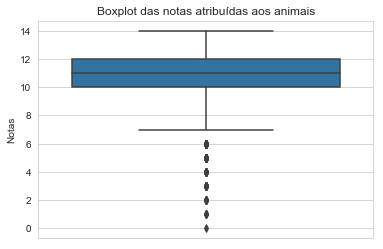

In [348]:
ax = sns.boxplot(
    data=df_tweets_archive[df_tweets_archive.rating_numerator <= 15].rating_numerator)
ax.set_title('Boxplot das notas atribuídas aos animais')
ax.set_ylabel('Notas')
ax.set_xticks([])

#### Insight

Neste gráfico podemos verificar depois de remover as notas discrepantes, ou seja superiores a 15, assim removendo outliers (valores que podiam chegar a 1776, sendo que a nota deveria ser até 10 visto que o denominador é 10 mas os usuários como brincadeira classificam os animais com notas a cima desse valor), e com média de 10.49 e desvio de 2.19. Observa-se que existe uma homogeniedade da variância no boxplot, visto que a diferença entre o terceiro quartil e a mediana assim como a diferença entre o primeiro quartil e a mediana parecem ser a mesmas.

### Relação entre contagem de retweets e tweets favoritos

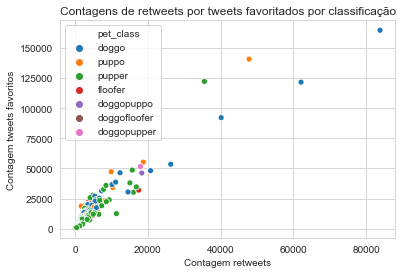

In [357]:
sns.set_style("whitegrid")

ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     hue='pet_class', data=df_tweets_archive)
ax.set_title('Contagens de retweets por tweets favoritados por classificação')
ax.set_xlabel('Contagem retweets')
ax.set_ylabel('Contagem tweets favoritos')

#### Insight

Esse é um gráfico de dispersão, entre a contagem de retweets e a contagem de tweets favoritos para cada classificação. Observa-se que a medida que aumenta a contagem de retweets aumenta a contagem de tweets favoritos (o que pode ser devido a maior visibilidade do tweet) e a classe que possui a maior evidência é a classe pupper. Vale salientar que é possível observar que a classe doggo possui observações com maiores números de retweets, consequentemente, maior contagem de tweets favoritos.

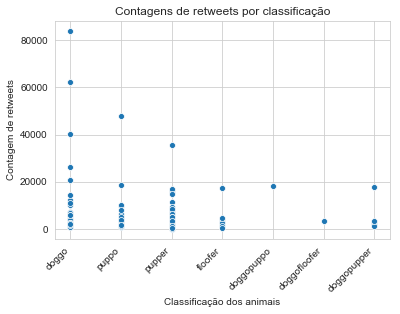

In [370]:
ax = sns.scatterplot(x="pet_class", y="retweet_count", data=df_tweets_archive)
labels = df_tweets_archive.pet_class.unique()[1:]
ax.set_xticklabels(rotation=45, ha='right', labels=labels)
ax.set_title('Contagens de retweets por classificação')
ax.set_xlabel('Classificação dos animais')
ax.set_ylabel('Contagem de retweets')

#### Insight

Por este gráfico é possível verificar que realmente a classificação doggo é a que possui o tweet com maior número de retweets, porém também podemos ver que pupper tem um grande concentração de retweets até 20000. Cachorros que possuem duas classificações são poucos com relação aos demais.

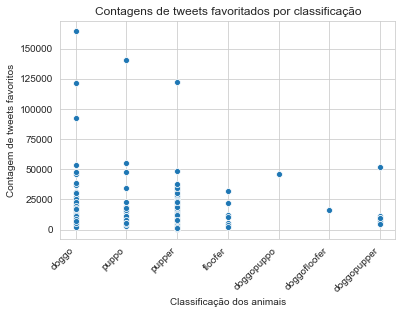

In [371]:
ax = sns.scatterplot(x="pet_class", y="favorite_count", data=df_tweets_archive)
labels = df_tweets_archive.pet_class.unique()[1:]
ax.set_xticklabels(rotation=45, ha='right', labels=labels)
ax.set_title('Contagens de tweets favoritados por classificação')
ax.set_xlabel('Classificação dos animais')
ax.set_ylabel('Contagem de tweets favoritos')

In [334]:
df_tweets_archive[['retweet_count', 'favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.929778
favorite_count,0.929778,1.000000


#### Insight

Ao comparar a correlação entre `retweet_count` e `favorite_count` pode-se notar que existe uma forte correlação positiva entre as variáveis, isto é a médida que a contagem de retweets aumenta significa o quão favorito aquele tweet é com os usuários.

### Contagem de tweets por data da post e classificação do animal

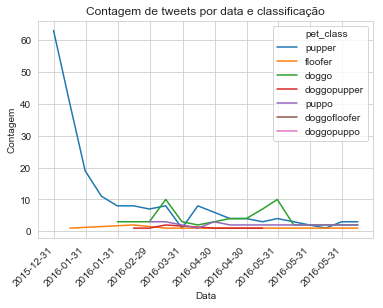

In [336]:
graph = df_tweets_archive.set_index('timestamp')
graph = graph.groupby([pd.Grouper(freq='M'), 'pet_class']).count()
graph = graph.reset_index(level=['timestamp', 'pet_class'])

ax = sns.lineplot(x='timestamp', y='tweet_id', data=graph, hue='pet_class')
ax.set_xticklabels(rotation=45, ha='right', labels=graph.timestamp.dt.date)
ax.set_title('Contagem de tweets por data e classificação')
ax.set_xlabel('Data')
ax.set_ylabel('Contagem')

#### Insight

Ao inicio é possível observar que a grande maioria dos tweets com classificação eram classificados unicamente como pupper, a medida que o tempo passa outras classificações são utilizadas e a contagem de tweets de cachorros denominados como pupper diminuiu. Observa-se que embora tenham ocorrido diferentes classificações, como doggo por exemplo, o número de tweets que possuem os animais denominados nessas classes diminuiu entre os anos.